In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(4)# + df['R']*0.13
#df['T'] = df['T'].round(2)#


In [3]:
df['T']

0        41
1        54
2        57
3        54
4        50
         ..
99995    75
99996    51
99997    59
99998    42
99999    54
Name: T, Length: 100000, dtype: int64

In [4]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [5]:
FRAC_ADMIT

A    0.39203
dtype: float64

In [6]:
len(df)

100000

<AxesSubplot:>

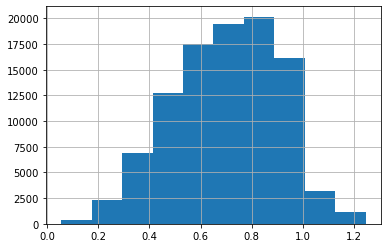

In [7]:
df['ml_outcomes'].hist()

In [8]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
26877,0,20,0.0548,16,20,-3.291633,-2.846771,0,0
61685,0,23,0.0716,19,23,-3.007015,-2.562153,0,0
64436,0,24,0.0782,20,24,-2.912143,-2.467280,0,0
96092,0,24,0.0782,21,24,-2.817270,-2.467280,0,0
69517,0,24,0.0782,19,24,-3.007015,-2.467280,0,0
...,...,...,...,...,...,...,...,...,...
27554,1,102,1.2424,102,118,4.867418,6.450753,1,1
73760,1,104,1.2437,104,121,5.057164,6.735371,1,1
61344,1,107,1.2452,107,125,5.341782,7.114862,1,1
18644,1,107,1.2452,107,124,5.341782,7.019989,1,1


In [9]:
#df['ml_outcomes'] = df['ml_outcomes'] + 1*df['R']

In [10]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [11]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [12]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants) per stratum
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()

In [13]:
# final info table
dff.sort_values(by='ml_outcomes')

,level_0,index,R,T,ml_outcomes,N
0,187,0,0,20,0.0548,1
1,186,1,0,23,0.0716,1
2,185,2,0,24,0.2346,3
103,184,103,1,20,0.3016,1
3,183,3,0,25,0.4265,5
105,182,105,1,22,0.6234,2
4,181,4,0,26,0.6510,7
5,180,5,0,27,0.8104,8
107,179,107,1,24,0.9708,3
92,178,92,0,114,0.9977,1


### Setup optimization problem 

In [14]:
from ortools.linear_solver import pywraplp


In [15]:
solver = pywraplp.Solver.CreateSolver('GLOP')


In [16]:
dff

,level_0,index,R,T,ml_outcomes,N
0,187,0,0,20,0.0548,1
1,186,1,0,23,0.0716,1
2,185,2,0,24,0.2346,3
3,183,3,0,25,0.4265,5
4,181,4,0,26,0.6510,7
5,180,5,0,27,0.8104,8
6,164,6,0,28,1.7648,16
7,158,7,0,29,2.8776,24
8,149,8,0,30,5.4726,42
9,148,9,0,31,5.9430,42


In [17]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'])] = numvar
    
    # Benefit of admitting people is total utility in that stratum
    objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
objective.SetMaximization()


In [18]:
# Currently we have no constraints 
solver.NumConstraints()

0

In [19]:
# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total admits cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))

39203


In [20]:
# Now we have one constraint
solver.NumConstraints()

1

## Add Equalized Odds Constraints

In [21]:
from collections import Counter

def convertListToProb(raw_list):
    counts = dict(Counter(raw_list))
    probs = {}
    for test_score in counts:
        probs[test_score]  = counts[test_score]/float(len(raw_list))
    return [(probs[t], t) for t in probs]

In [22]:
T_blacks_list = df[df['R']==0][['T','T_black']].groupby('T')['T_black'].apply(list).reset_index(name='T_blacks')
T_blacks_list['probs'] = T_blacks_list['T_blacks'].apply(convertListToProb)
didntexist = 0
exists = 0
for ix, row in T_blacks_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    White_T = row['T']
    Blacks_Ts = row['probs']        
    cf_fair_stratum.SetCoefficient(vars_cache[(0.0, White_T)], -1.0)
    for prob in Blacks_Ts:
        if (1.0, prob[1]) not in vars_cache:
            vars_cache[(1.0, prob[1])] = solver.NumVar(0.0, 1.0, str((1.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
        cf_fair_stratum.SetCoefficient(vars_cache[(1.0, prob[1])], prob[0])
didntexist,exists

(8, 551)

In [23]:
T_whites_list = df[df['R']==1][['T','T_white']].groupby('T')['T_white'].apply(list).reset_index(name='T_whites')
T_whites_list['probs'] = T_whites_list['T_whites'].apply(convertListToProb)
didntexist = 0
exists = 0

for ix, row in T_whites_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    Black_T = row['T']
    White_Ts = row['probs']
    
    cf_fair_stratum.SetCoefficient(vars_cache[(1.0, Black_T)], -1.0)
    for prob in White_Ts:
        if (0.0, prob[1]) not in vars_cache:
            vars_cache[(0.0, prob[1])] = solver.NumVar(0.0, 1.0, str((0.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
            
        cf_fair_stratum.SetCoefficient(vars_cache[(0.0, prob[1])], prob[0])
didntexist,exists  

(2, 504)

In [24]:
solver.NumConstraints()

189

## Solve linear program

In [25]:
solver.ABNORMAL

4

In [26]:
status = solver.Solve()


In [27]:
status

0

In [28]:
solver.OPTIMAL

0

In [29]:
row = []
admit = []

for i in applicant_stratum:
    row.append(int(str(i)))
    admit.append(i.solution_value())

df_decisions = pd.DataFrame({'row_id':row,'decision':admit})

In [30]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.361840
2,2,0.366836
3,3,0.376322
4,4,0.378114
5,5,0.381180
6,6,0.386088
7,7,0.386856
8,8,0.387468
9,9,0.388591


In [31]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,row_id,decision
39,0,39,0,61,1560.8734,2111,39,0.391160
37,1,37,0,59,1551.9769,2213,37,0.391111
38,2,38,0,60,1535.0910,2130,38,0.391136
40,3,40,0,62,1525.9595,2015,40,0.391188
35,4,35,0,57,1514.9295,2295,35,0.391065
36,5,36,0,58,1505.6910,2211,36,0.391088
41,6,41,0,63,1499.0448,1936,41,0.391216
42,7,42,0,64,1487.5328,1882,42,0.391246
43,8,43,0,65,1458.3170,1810,43,0.391279
34,9,34,0,56,1440.4560,2256,34,0.391044


In [32]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,row_id,decision
0,187,0,0,20,0.0548,1,0,0.000000
103,184,103,1,20,0.3016,1,103,0.361840
104,171,104,1,21,1.2256,4,104,0.376827
105,182,105,1,22,0.6234,2,105,0.372475
106,155,106,1,23,3.1740,10,106,0.382432
1,186,1,0,23,0.0716,1,1,0.361840
107,179,107,1,24,0.9708,3,107,0.382254
2,185,2,0,24,0.2346,3,2,0.366836
3,183,3,0,25,0.4265,5,3,0.376322
108,163,108,1,25,1.9818,6,108,0.387034


In [33]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
39,0,39,0,61,1560.8734,2111,39,0.391160
37,1,37,0,59,1551.9769,2213,37,0.391111
38,2,38,0,60,1535.0910,2130,38,0.391136
40,3,40,0,62,1525.9595,2015,40,0.391188
35,4,35,0,57,1514.9295,2295,35,0.391065
36,5,36,0,58,1505.6910,2211,36,0.391088
41,6,41,0,63,1499.0448,1936,41,0.391216
42,7,42,0,64,1487.5328,1882,42,0.391246
43,8,43,0,65,1458.3170,1810,43,0.391279
34,9,34,0,56,1440.4560,2256,34,0.391044


In [34]:
len(xxx_)

188

In [35]:
xxx.to_csv('./decision.csv')

In [36]:
solution = pd.read_csv('./decision.csv')

In [37]:
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
39,0,39,0,61,1560.8734,2111,39,0.391160
37,1,37,0,59,1551.9769,2213,37,0.391111
38,2,38,0,60,1535.0910,2130,38,0.391136
40,3,40,0,62,1525.9595,2015,40,0.391188
35,4,35,0,57,1514.9295,2295,35,0.391065
36,5,36,0,58,1505.6910,2211,36,0.391088
41,6,41,0,63,1499.0448,1936,41,0.391216
42,7,42,0,64,1487.5328,1882,42,0.391246
43,8,43,0,65,1458.3170,1810,43,0.391279
34,9,34,0,56,1440.4560,2256,34,0.391044


In [38]:
(xxx['ml_outcomes']*xxx['decision']).sum()

27477.656698163784

In [39]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [40]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [41]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [42]:
len(xxx)

188

In [43]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [44]:
file = open('./lp_results.csv','w')
file.write('{}\t{}\t{}\n'.format('Policy Name','Frac Diverse Candidates','Total Graduated'))
file.write('{}\t{}\t{}\n'.format('Random',str(FRAC_RANDOM_POLICY),str(SUM_BP_RAND_POLICY)))
file.write('{}\t{}\t{}\n'.format('Counterfactual Fairness',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()
